In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [1]:
!pip install ssqueezepy
!pip install timm
!pip install pytorch-lightning
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.2/127.2 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 1.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadat

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import mne
from ssqueezepy import cwt
from ssqueezepy.visuals import plot, imshow
import re
import random
from PIL import Image

In [173]:
data = scipy.io.loadmat('/content/drive/MyDrive/ecg emotion/DREAMER.mat')

In [6]:
PATIENTS = 23
VIDEOS = 18

Features = {
    'Age' : 0,
    'Gender': 1,
    'EEG' : 2,
    'ECG' : 3,
    'Valence' : 4,
    'Arousal' : 5,
    'Dominance' : 6
}


signal_types = {
    'BaseLine' :0,
    'Stimulie' :1
}


def retrieve_data(Sample_index, Feature_name, Video_idx):

    return data['DREAMER']['Data'][0,0][0][Sample_index][0][0][Features[Feature_name]][Video_idx]

def retrieve_signals(Sample_index, Feature_type, signal_type):

    if Feature_type not in ('EEG', 'ECG'):
        raise ValueError(f"Invalid Feature_type: {Feature_type}. Feature_type must be 'EEG' or 'ECG'.")

    return data['DREAMER']['Data'][0,0][0][Sample_index][0][0][Features[Feature_type]][0][0][signal_types[signal_type]]

In [7]:
ECG_Stimuli = []
ECG_Baseline = []
EEG_Baseline = []
EEG_Stimuli = []

for i in range(PATIENTS):
    baseline = retrieve_signals(i,'ECG','BaseLine')
    ECG_Baseline.append(baseline)
    stimuli = retrieve_signals(i,'ECG','Stimulie')
    ECG_Stimuli.append(stimuli)
    baseline = retrieve_signals(i,'EEG','BaseLine')
    EEG_Baseline.append(baseline)
    stimuli = retrieve_signals(i,'EEG','Stimulie')
    EEG_Stimuli.append(stimuli)

In [8]:
def pad_signals_to_max(signals, max_length):
    """Pad signals to the maximum length."""
    padded = []
    for signal in signals:
        pad_len = max_length - signal.shape[0]
        if pad_len > 0:
            # Pad on the time dimension (assumed to be axis 0)
            padded_signal = np.pad(signal, ((0, pad_len), (0, 0)), mode='constant', constant_values=0)
        else:
            padded_signal = signal
        padded.append(padded_signal)
    return np.array(padded)

# Calculate maximum length across all signal types
max_length = max(
    max(s.shape[0] for s in EEG_Stimuli),
    max(s.shape[0] for s in ECG_Stimuli),
    max(s.shape[0] for s in EEG_Baseline),
    max(s.shape[0] for s in ECG_Baseline)
)

# Pad all signals to this maximum length
EEG_Stimuli_padded = pad_signals_to_max(EEG_Stimuli, max_length)
ECG_Stimuli_padded = pad_signals_to_max(ECG_Stimuli, max_length)
EEG_Baseline_padded = pad_signals_to_max(EEG_Baseline, max_length)
ECG_Baseline_padded = pad_signals_to_max(ECG_Baseline, max_length)


In [174]:
big_df = pd.DataFrame()
df = pd.DataFrame()
patients = []
for i in range(PATIENTS): # for i in every patient
    for j in range(VIDEOS): # for j in every Video
        patient_index = [i] * len(EEG_Stimuli[i][j][0])
        video_index = [j] * len(EEG_Stimuli[i][j][0])
        valence = [retrieve_data(i, 'Valence', j)[0]] * len(EEG_Stimuli[i][j][0])
        arousal = [retrieve_data(i, 'Arousal', j)[0]] * len(EEG_Stimuli[i][j][0])
        dominance = [retrieve_data(i, 'Dominance', j)[0]] * len(EEG_Stimuli[i][j][0])
        electrodes = []
        for k in range(14): # for k in every electrode
            electrode = []
            for l,row  in enumerate(EEG_Stimuli[i][j][0]):
                electrode.append(row[k])
            electrodes.append(electrode)
        Dict = {
            'patient_index' : patient_index,
            'video_index' : video_index,
            'valence' : valence,
            'arousal' : arousal,
            'dominance' : dominance
        }
        columns_list = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
        for idx , key in enumerate(columns_list):
            Dict[key] = electrodes[idx]
        df = pd.DataFrame(Dict)
        patients.append(df)
big_df = pd.concat(patients)

In [ ]:
big_df.video_index.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17], dtype=int64)

In [ ]:
big_df.patient_index.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22], dtype=int64)

In [ ]:
big_df

,patient_index,video_index,valence,arousal,dominance,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
0,0,0,4,3,2,4388.205128,4102.564103,4219.487179,4465.128205,4370.769231,4399.487179,4443.076923,4023.076923,4365.128205,4310.256410,3953.846154,4454.358974,4326.153846,4165.128205
1,0,0,4,3,2,4375.897436,4093.846154,4252.820513,4522.564103,4435.897436,4411.794872,4488.717949,4108.717949,4399.487179,4384.615385,4007.692308,4466.666667,4372.820513,4247.179487
2,0,0,4,3,2,4378.461538,4091.282051,4230.256410,4488.205128,4370.256410,4402.564103,4461.025641,4077.435897,4378.461538,4328.717949,3986.153846,4461.025641,4328.205128,4203.589744
3,0,0,4,3,2,4393.846154,4101.025641,4193.333333,4418.974359,4270.256410,4392.307692,4411.282051,3982.564103,4336.410256,4213.333333,3930.256410,4442.564103,4261.025641,4100.000000
4,0,0,4,3,2,4396.410256,4108.717949,4210.769231,4436.410256,4310.769231,4401.025641,4426.666667,3980.512821,4349.743590,4238.461538,3945.128205,4446.666667,4289.743590,4115.384615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23803,22,17,2,4,2,4400.000000,4106.153846,4163.589744,4415.897436,4311.282051,4378.974359,4493.333333,3957.948718,4334.871795,4299.487179,3944.102564,4454.358974,4341.025641,4160.000000
23804,22,17,2,4,2,4371.794872,4100.512821,4164.102564,4406.153846,4311.282051,4381.538462,4490.256410,3941.538462,4311.794872,4278.974359,3920.000000,4430.769231,4310.256410,4145.128205
23805,22,17,2,4,2,4370.256410,4097.948718,4155.897436,4408.205128,4313.333333,4380.000000,4490.256410,3945.641026,4315.384615,4274.871795,3923.589744,4441.538462,4301.538462,4136.410256
23806,22,17,2,4,2,4373.846154,4087.692308,4158.461538,4409.230769,4312.307692,4376.410256,4489.743590,3950.256410,4321.538462,4275.384615,3921.538462,4432.307692,4295.384615,4142.051282


In [ ]:
grouped_df = big_df.groupby(['patient_index', 'video_index']).mean().reset_index()

In [ ]:
grouped_df.to_csv('grouped_df.csv',sep=',')

In [15]:
grouped_df=pd.read_csv('/content/drive/MyDrive/ecg emotion/grouped_df.csv',sep=',')

In [17]:
def determine_emotion(row):
    values = {'valence': row['valence'], 'arousal': row['arousal'], 'dominance': row['dominance']}
    return max(values, key=values.get)  # Returns the key with the highest value

grouped_df['emotion_label'] = grouped_df.apply(determine_emotion, axis=1)


In [ ]:
groups=big_df.groupby(['patient_index','video_index'])
grp_keys=list(groups.groups.keys())
print(grp_keys)

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (5, 16), (5, 17), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10)

In [ ]:
def convertDF2MNE(sub):
    info = mne.create_info(list(sub.columns), ch_types=['eeg'] * len(sub.columns), sfreq=128)
    info.set_montage('standard_1020')
    data=mne.io.RawArray(sub.T, info)
    data.set_eeg_reference()
    #data.filter(l_freq=1,h_freq=30)
    epochs=mne.make_fixed_length_epochs(data,duration=4,overlap=0.5)
    return epochs.get_data()


In [ ]:
grpno=grp_keys[0]
grp1=groups.get_group(grpno).drop(['patient_index','video_index'],axis=1)
label_valence=grp1['valence']
label_arousal=grp1['arousal']
label_dominance=grp1['dominance']
patient_id=grpno[0]
grp1=grp1.drop(['valence','arousal','dominance'],axis=1)
grp1

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
0,4388.205128,4102.564103,4219.487179,4465.128205,4370.769231,4399.487179,4443.076923,4023.076923,4365.128205,4310.256410,3953.846154,4454.358974,4326.153846,4165.128205
1,4375.897436,4093.846154,4252.820513,4522.564103,4435.897436,4411.794872,4488.717949,4108.717949,4399.487179,4384.615385,4007.692308,4466.666667,4372.820513,4247.179487
2,4378.461538,4091.282051,4230.256410,4488.205128,4370.256410,4402.564103,4461.025641,4077.435897,4378.461538,4328.717949,3986.153846,4461.025641,4328.205128,4203.589744
3,4393.846154,4101.025641,4193.333333,4418.974359,4270.256410,4392.307692,4411.282051,3982.564103,4336.410256,4213.333333,3930.256410,4442.564103,4261.025641,4100.000000
4,4396.410256,4108.717949,4210.769231,4436.410256,4310.769231,4401.025641,4426.666667,3980.512821,4349.743590,4238.461538,3945.128205,4446.666667,4289.743590,4115.384615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25467,4397.435897,4112.307692,4209.230769,4436.410256,4364.615385,4375.384615,4460.512821,4004.102564,4356.410256,4323.589744,3965.641026,4476.923077,4341.538462,4192.307692
25468,4387.179487,4104.102564,4218.461538,4451.794872,4389.743590,4382.051282,4475.897436,4023.589744,4367.179487,4348.205128,3971.794872,4472.307692,4354.358974,4192.307692
25469,4371.282051,4092.307692,4237.435897,4490.256410,4421.538462,4391.282051,4505.128205,4077.435897,4389.743590,4382.564103,3996.923077,4475.384615,4377.948718,4230.256410
25470,4371.794872,4089.743590,4214.358974,4466.666667,4391.794872,4377.948718,4478.461538,4049.230769,4365.641026,4348.717949,3973.333333,4466.153846,4351.794872,4206.666667


In [ ]:
test=convertDF2MNE(grp1)
test.shape

Creating RawArray with float64 data, n_channels=14, n_times=25472
    Range : 0 ... 25471 =      0.000 ...   198.992 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
56 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 56 events and 512 original time points ...
0 bad epochs dropped


(56, 14, 512)

In [ ]:
!mkdir scaleogram

A subdirectory or file scaleogram already exists.


In [ ]:
Wx, scales = cwt(test[0], 'morlet')
Wx.shape

(14, 230, 512)

(14, 230, 512)
[[  0.62996566+0.00261904j  -0.6224363 +0.0694089j
    0.60064083-0.13716446j ...   0.5994873 +0.15340202j
   -0.6241205 -0.08046003j   0.63262606+0.00263377j]
 [  0.96539986+0.00362679j  -0.9521777 +0.1151952j
    0.91404694-0.22612754j ...   0.9184598 +0.25335744j
   -0.9617013 -0.13299057j   0.9766753 +0.00364702j]
 [  1.4090782 +0.00470799j  -1.3866364 +0.18358234j
    1.3222107 -0.35773066j ...   1.339091  +0.4018131j
   -1.4123074 -0.21125072j   1.4377452 +0.00473402j]
 ...
 [ -0.455989  -0.0243113j   -0.45558766-0.02937028j
   -0.45513403-0.03442278j ...  -0.6292094 +0.02552537j
   -0.6295733 +0.0172718j   -0.6298262 +0.00901269j]
 [ -4.281255  -0.09297085j  -4.2797914 -0.14549841j
   -4.2776833 -0.19800405j ...  -4.282751  +0.06486001j
   -4.283225  +0.01229613j  -4.283054  -0.04026958j]
 [-13.701783  -0.29728436j -13.6971035 -0.46540394j
  -13.690361  -0.63345337j ... -13.703441  +0.2072418j
  -13.704952  +0.03906396j -13.7044    -0.12911984j]] (230, 512)


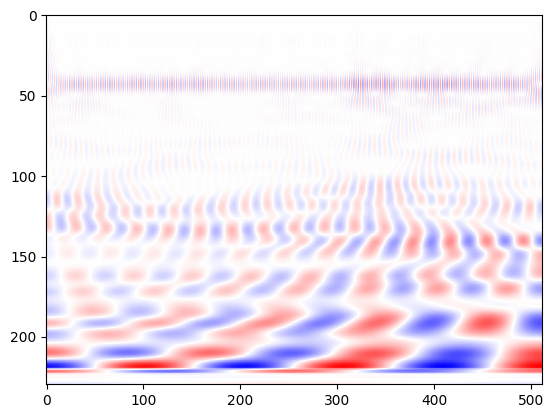

In [ ]:
print(Wx.shape)
print(Wx[0], Wx[0].shape)
imshow(Wx[0])

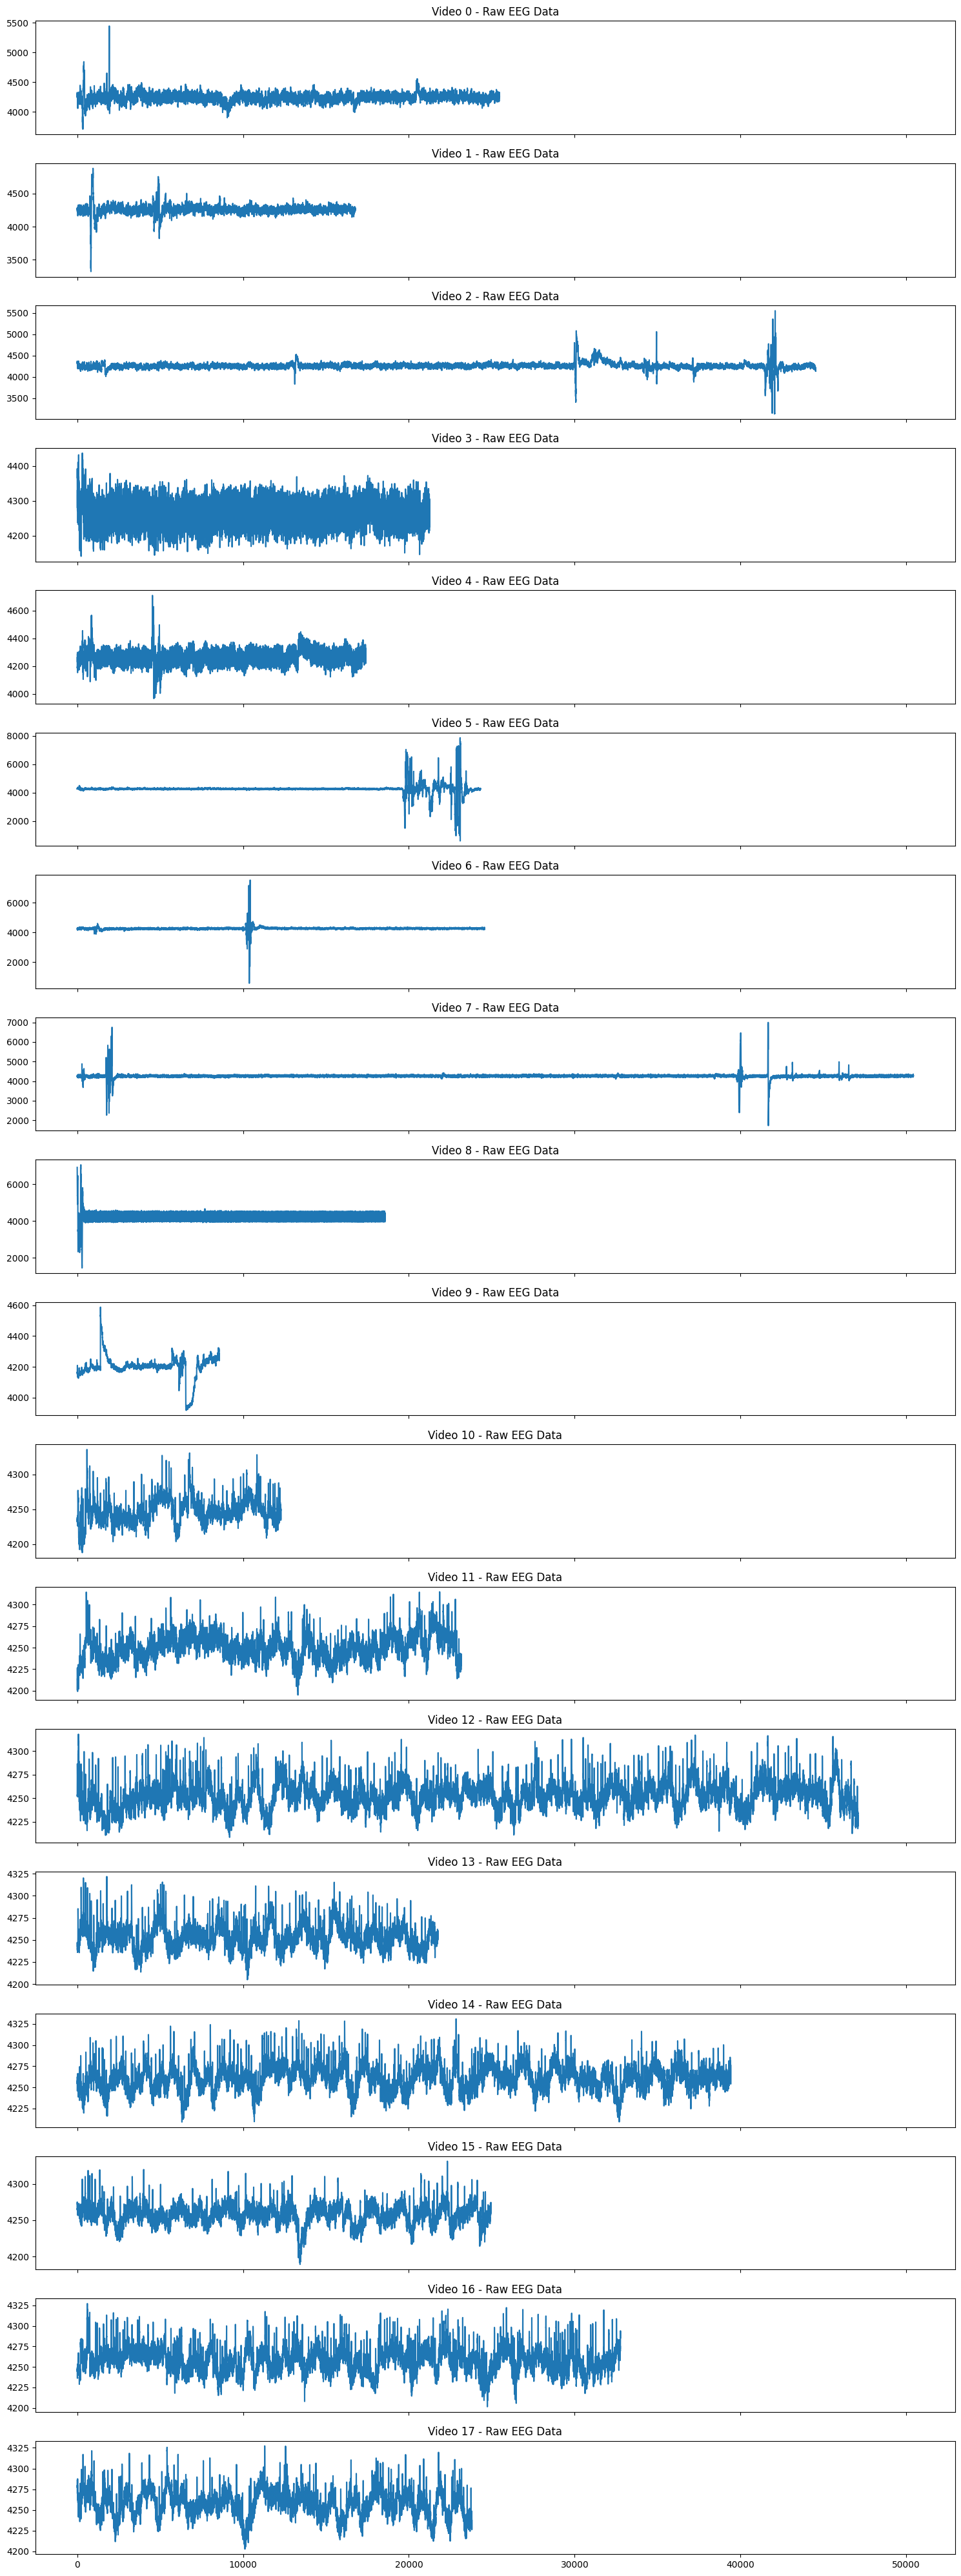

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'groups' is already defined and 'grp_keys' is populated
patient_id = 0  # Change this ID based on the patient you want to analyze
video_indices = range(18)  # For 18 videos

fig, axes = plt.subplots(nrows=18, figsize=(15, 40), sharex=True)
for j, ax in zip(video_indices, axes):
    grpno = (patient_id, j)  # Assuming grp_keys are tuples of (patient_index, video_index)
    grp = groups.get_group(grpno).drop(['patient_index', 'video_index'], axis=1)
    raw_eeg_data = grp.drop(['valence', 'arousal', 'dominance'], axis=1).mean(axis=1)  # Average across electrodes for simplicity
    ax.plot(raw_eeg_data)
    ax.set_title(f'Video {j} - Raw EEG Data')
plt.tight_layout()
plt.show()


In [ ]:
patient_id=1
for patient_id in range(patient_id):
    print(i)

0


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import mne
from mne.time_frequency import tfr_array_morlet
import random

# Ensure these functions or data structures are properly defined elsewhere in your project
# groups = ... (Your DataFrameGroupBy object for EEG data)
# def convertDF2MNE(data): ... (Your function to convert data into MNE-compatible format)

# Configurations
patient_id = 0  # Adjust as needed for different patients
sfreq = 128  # Sampling frequency of EEG data
frequencies = np.logspace(np.log10(6), np.log10(30), num=50)  # Increase frequency resolution
n_cycles = frequencies / 6  # Decrease cycles for shorter signals

# Lists for storing metadata
grpnos, labels, paths = [], [], []


while patient_id!=23:
    print(patient_id)
# Process data for one specific patient across all videos
    for j in range(18):  # Assuming 18 videos are available
        grpno = (patient_id, j)  # Tuple for group identification
        grp = groups.get_group(grpno).drop(['patient_index', 'video_index'], axis=1)
        label = int(grp['valence'].unique()[0])  # Safely extract unique valence label

        # Convert EEG data to MNE format
        data = convertDF2MNE(grp.drop(['valence', 'arousal', 'dominance'], axis=1))

        # Iterate through each trial in the dataset
        for c, x in enumerate(data):
            if random.random() < 0.9:
                continue  # Skip 90% of trials to focus on a subset
            else:
                # Apply the wavelet transform with zero_mean explicitly set
                power = tfr_array_morlet(x[np.newaxis, :], sfreq=sfreq, freqs=frequencies, n_cycles=n_cycles, output='power', zero_mean=True)
                Wx = np.abs(power)  # Absolute values of the wavelet transform

                # Normalize and apply logarithmic scaling for better dynamic range handling
                Wx_normalized = np.log1p(Wx)
                Wx_normalized = ((Wx_normalized - Wx_normalized.min()) / (Wx_normalized.max() - Wx_normalized.min()) * 255).astype(np.uint8)

                # Prepare directories and file paths
                path = os.path.join('./scaleogram', f'subvideo_{patient_id}_{j}')
                os.makedirs(path, exist_ok=True)
                image_path = os.path.join(path, f'trial_{c}.jpeg')

                # Create and save the image using a perceptually uniform colormap
                img = plt.imsave(image_path, Wx_normalized[0, 0, :, :], cmap='inferno')

                # Enhance contrast using PIL
                im = Image.open(image_path)
                enhancer = ImageEnhance.Contrast(im)
                im_enhanced = enhancer.enhance(2.0)  # Increase contrast factor to 2.0
                im_enhanced.save(image_path)

                # Store metadata
                grpnos.append(patient_id)
                labels.append(label)
                paths.append(image_path)

    if patient_id != 23:
        patient_id=patient_id+1

# Indicate completion
print("Processing complete.")


1
Creating RawArray with float64 data, n_channels=14, n_times=25472
    Range : 0 ... 25471 =      0.000 ...   198.992 secs
Ready.


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
56 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 56 events and 512 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=14, n_times=16768
    Range : 0 ... 16767 =      0.000 ...   130.992 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
37 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 37 events and 512 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=14, n_times=44544
    Range : 0 ... 44543 =      0.000 ...   347.992 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
N

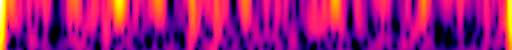

In [175]:
image_path = '/content/drive/MyDrive/ecg emotion/reorganized_scaleogram/1/trial_0.jpeg'  # Replace with the actual path to your image

# Step 3: Display the image
from IPython.display import Image
from IPython.display import display

display(Image(filename=image_path))

In [ ]:
df_scale=pd.DataFrame(zip(paths,labels,grpnos),columns=['path','label','group'])
df_scale.shape

(2265, 3)

In [ ]:
df_scale['label'] = df_scale['label'].astype('string')

In [ ]:
df_scale.dtypes

path             object
label    string[python]
group             int64
dtype: object

In [ ]:
df_scale.label.unique()

<StringArray>
['3', '2', '5', '1', '4']
Length: 5, dtype: string

In [ ]:
df_scale.to_csv('dataset_&_labels.csv', index=False, header=True)

In [ ]:
# print(len(images),len(labels))
# imshow(images[205], "Label: "+str(labels[205]))

In [ ]:
from sklearn.model_selection import train_test_split
from keras.src.legacy.preprocessing.image import ImageDataGenerator
train_df, test_df = train_test_split(df_scale.drop('group', axis=1), test_size=0.2, random_state=43)

In [ ]:
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()
train_gen = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                x_col="path",
                                                y_col="label",
                                                target_size=(255, 255),
                                                batch_size=32,
                                                class_mode="categorical")

test_gen = test_datagen.flow_from_dataframe(dataframe=test_df,
                                              x_col="path",
                                              y_col="label",
                                              target_size=(255, 255),
                                              batch_size=32,
                                              class_mode="categorical")

Found 1812 validated image filenames belonging to 5 classes.
Found 453 validated image filenames belonging to 5 classes.


In [ ]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(255, 255, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\c23005186\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 253, 253, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 124, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    62,980,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,001,029 (240.33 MB)

 Trainable params: 63,001,029 (240.33 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf
with tf.device('/GPU:0'):
    h3 = model.fit(train_gen, epochs=10, validation_data=test_gen)

Epoch 1/10


C:\Users\c23005186\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.2043 - loss: 1428.3229 - val_accuracy: 0.2097 - val_loss: 1.6100
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.2466 - loss: 1.6023 - val_accuracy: 0.2075 - val_loss: 1.6191
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.2829 - loss: 1.5593 - val_accuracy: 0.2053 - val_loss: 1.6192
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.3424 - loss: 1.4448 - val_accuracy: 0.2163 - val_loss: 1.8775
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.4891 - loss: 1.2106 - val_accuracy: 0.2296 - val_loss: 2.1802
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.5651 - loss: 1.0646 - val_accuracy: 0.2141 - val_loss: 2.4769
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.6264 - loss: 0.8647 - val_accuracy: 0.2031 - val_loss: 3.5057
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.6569 - loss: 0.7892 - val_accuracy: 0.2097 - val_loss: 4.5980


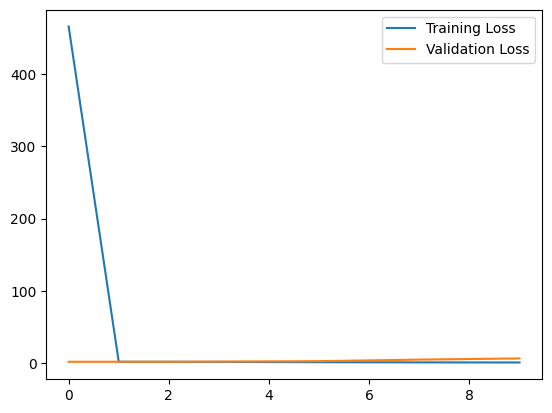

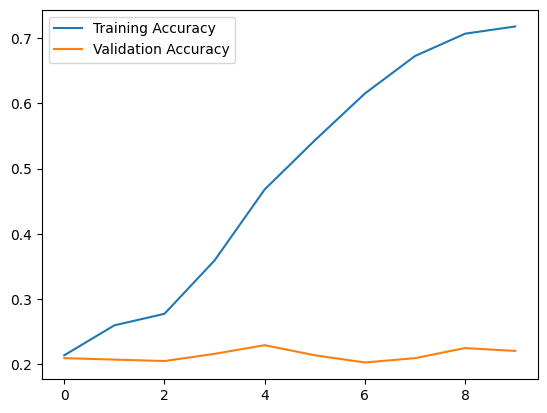

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Plot the loss
plt.plot(h3.history['loss'], label='Training Loss')
plt.plot(h3.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# Plot the accuracy
plt.plot(h3.history['accuracy'], label='Training Accuracy')
plt.plot(h3.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
# Example of custom generator to load image sequences for LSTM
def load_image_sequences(dataframe, batch_size, sequence_length):
    num_samples = len(dataframe)
    while True:  # Loop indefinitely
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_data = []
            batch_labels = []
            for i in range(start, end):
                sequence = []
                # Assuming there is a mechanism or pattern to fetch sequential images
                for j in range(sequence_length):
                    # Load images in sequence, here we assume paths and labels are ordered
                    img_path = dataframe.iloc[i + j]['path'] if i + j < num_samples else dataframe.iloc[num_samples - 1]['path']
                    img = load_img(img_path, target_size=(255, 255))
                    img = img_to_array(img)
                    sequence.append(img)
                batch_data.append(sequence)
                label = dataframe.iloc[i]['label']
                batch_labels.append(to_categorical(label, num_classes=5))  # Adjust num_classes accordingly
            # Convert batch_data and batch_labels to numpy arrays
            yield (np.array(batch_data), np.array(batch_labels))

# Use this custom generator to load data
train_gen = load_image_sequences(train_df, batch_size=32, sequence_length=5)  # Adjust sequence_length as needed
test_gen = load_image_sequences(test_df, batch_size=32, sequence_length=5)


In [17]:
import os

# List directories in BASE_DIR
directories = [d for d in os.listdir(BASE_DIR) if os.path.isdir(os.path.join(BASE_DIR, d))]
print("Directories (classes) found:", directories)
print("Number of classes found:", len(directories))


Directories (classes) found: ['subvideo_9_8', 'subvideo_9_6', 'subvideo_9_4', 'subvideo_9_7', 'subvideo_9_3', 'subvideo_9_5', 'subvideo_9_2', 'subvideo_9_12', 'subvideo_9_17', 'subvideo_9_11', 'subvideo_9_16', 'subvideo_9_15', 'subvideo_9_14', 'subvideo_9_13', 'subvideo_9_10', 'subvideo_9_1', 'subvideo_9_0', 'subvideo_8_4', 'subvideo_8_5', 'subvideo_8_7', 'subvideo_8_2', 'subvideo_8_6', 'subvideo_8_8', 'subvideo_8_3', 'subvideo_8_16', 'subvideo_8_17', 'subvideo_8_15', 'subvideo_8_1', 'subvideo_8_12', 'subvideo_8_11', 'subvideo_8_14', 'subvideo_8_13', 'subvideo_8_0', 'subvideo_8_10', 'subvideo_7_7', 'subvideo_7_8', 'subvideo_7_9', 'subvideo_7_3', 'subvideo_7_6', 'subvideo_7_5', 'subvideo_7_15', 'subvideo_7_13', 'subvideo_7_14', 'subvideo_7_2', 'subvideo_7_17', 'subvideo_7_16', 'subvideo_7_12', 'subvideo_7_11', 'subvideo_7_1', 'subvideo_7_10', 'subvideo_6_6', 'subvideo_6_7', 'subvideo_7_0', 'subvideo_6_8', 'subvideo_6_5', 'subvideo_6_9', 'subvideo_6_4', 'subvideo_6_3', 'subvideo_6_17', '

In [5]:
df_scale=pd.read_csv('/content/drive/MyDrive/ecg emotion/dataset_&_labels.csv', sep=',')

In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_df, test_df = train_test_split(df_scale.drop('group', axis=1), test_size=0.2, random_state=43)

In [28]:
import os
import pandas as pd

# Base directory where the 'scaleogram' folder is located
base_dir = '/content/drive/MyDrive/ecg emotion'
scaleogram_dir = os.path.join(base_dir)

# CSV file path
csv_path = os.path.join(base_dir, 'dataset_&_labels.csv')

# Read the CSV into a DataFrame
df = pd.read_csv(csv_path)
df.columns = ['path', 'label', 'group']

# Destination directory for the reorganized datasets
dest_dir = os.path.join(base_dir, 'reorganized_scaleogram')

# Ensure the destination directory exists
os.makedirs(dest_dir, exist_ok=True)

# Process each file
for index, row in df.iterrows():
    # Adjusting the file path
    src_path = os.path.join(scaleogram_dir, row['path'].strip('.').replace('\\', '/').lstrip('/'))

    # Create a label-specific directory
    label_dir = os.path.join(dest_dir, str(row['label']))
    os.makedirs(label_dir, exist_ok=True)

    # Construct the destination path
    dest_path = os.path.join(label_dir, os.path.basename(src_path))

    # Move the file if it exists
    if os.path.exists(src_path):
        os.rename(src_path, dest_path)
    else:
        print(f"File not found: {src_path}")  # Notify if a file can't be found

print("Reorganization complete.")


Reorganization complete.


In [11]:
train_df['label'] = train_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)


In [14]:
train_df['path'] = train_df['path'].str.replace(r'\\', '/', regex=True)
test_df['path'] = test_df['path'].str.replace(r'\\', '/', regex=True)

# Print to verify changes
print(train_df['path'].head())


500        ./scaleogram/subvideo_5_8/trial_9.jpeg
1097     ./scaleogram/subvideo_11_11/trial_2.jpeg
363       ./scaleogram/subvideo_4_4/trial_24.jpeg
2043    ./scaleogram/subvideo_20_14/trial_14.jpeg
910      ./scaleogram/subvideo_9_14/trial_64.jpeg
Name: path, dtype: object


In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Base directory for the reorganized dataset
base_dir = '/content/drive/MyDrive/ecg emotion/reorganized_scaleogram'

# Initialize the ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=20,  # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # Randomly shift images vertically (fraction of total height)
    shear_range=0.2,  # Shear Intensity (Shear angle in counter-clockwise direction in degrees)
    zoom_range=0.2,  # Randomly zoom image
    horizontal_flip=True,  # Randomly flip images
    fill_mode='nearest',  # Set mode for filling points outside the input boundaries
    validation_split=0.2  # Set validation split
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    base_dir,  # This is the source directory for training images
    target_size=(255, 255),  # All images will be resized to 255x255
    batch_size=32,
    class_mode='categorical',  # Since we use categorical crossentropy loss, we need categorical labels
    subset='training'  # Set as training data
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    base_dir,  # Same directory as training data
    target_size=(255, 255),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Set as validation data
)

print("Data generators are ready!")


Found 376 images belonging to 5 classes.
Found 91 images belonging to 5 classes.
Data generators are ready!


In [35]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(255, 255, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/10
11/11 [==============================] - 73s 6s/step - loss: 11.1481 - accuracy: 0.2587 - val_loss: 1.9135 - val_accuracy: 0.2812
Epoch 2/10
11/11 [==============================] - 8s 720ms/step - loss: 1.7101 - accuracy: 0.2238 - val_loss: 1.6070 - val_accuracy: 0.2500
Epoch 3/10
11/11 [==============================] - 10s 894ms/step - loss: 1.6083 - accuracy: 0.2238 - val_loss: 1.6075 - val_accuracy: 0.1875
Epoch 4/10
11/11 [==============================] - 8s 782ms/step - loss: 1.6048 - accuracy: 0.2297 - val_loss: 1.5800 - val_accuracy: 0.2188
Epoch 5/10
11/11 [==============================] - 8s 782ms/step - loss: 1.6132 - accuracy: 0.2209 - val_loss: 1.6062 - val_accuracy: 0.2812
Epoch 6/10
11/11 [==============================] - 10s 871ms/step - loss: 1.6023 - accuracy: 0.2238 - val_loss: 1.6055 - val_accuracy: 0.2031
Epoch 7/10
11/11 [==============================] - 10s 937ms/step - loss: 1.6023 - accuracy: 0.2301 - val_loss: 1.5897 - val_accuracy: 0.2500
Epoc

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


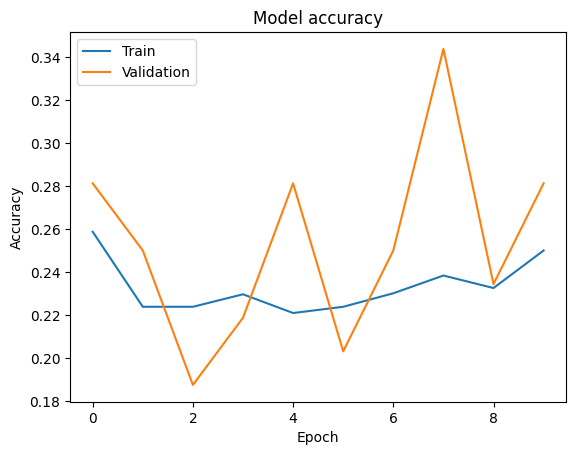

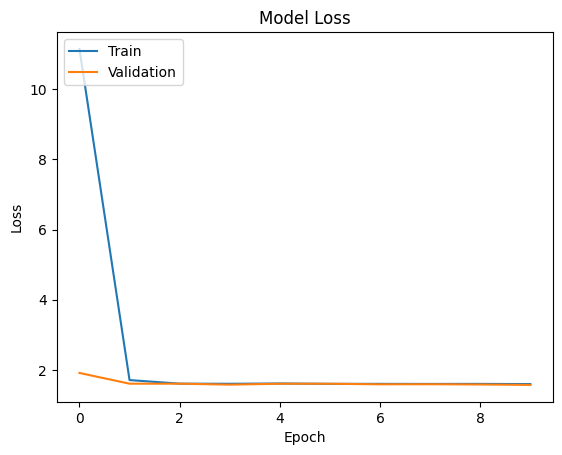

In [36]:
# Define the number of epochs to train for
epochs = 10

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch.
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size  # Total number of steps (batches of samples) to yield from `validation_generator` before stopping at the end of every epoch.
)

# Save the model
model.save('/content/drive/MyDrive/ecg emotion/my_model.h5')

# Optionally, plot the training history for accuracy and loss
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [80]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Model architecture
model = Sequential([
    Conv2D(32, (3, 3), input_shape=(255, 255, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),  # Increased dropout rate for better regularization
    Dense(5, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/ecg emotion/best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

# Define the number of epochs
epochs = 100  # Increased number of epochs for more extensive training

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, model_checkpoint]
)

# Save the final model
model.save('/content/drive/MyDrive/ecg emotion/my_final_model.h5')

# Plotting the training history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 5.9800 - accuracy: 0.2209

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 28s 2s/step - loss: 5.9800 - accuracy: 0.2209 - val_loss: 1.6502 - val_accuracy: 0.1719
Epoch 2/100
11/11 [==============================] - 23s 2s/step - loss: 1.6228 - accuracy: 0.1860 - val_loss: 1.6096 - val_accuracy: 0.1562
Epoch 3/100
11/11 [==============================] - 17s 2s/step - loss: 1.6145 - accuracy: 0.2035 - val_loss: 1.6086 - val_accuracy: 0.1562
Epoch 4/100
11/11 [==============================] - 17s 2s/step - loss: 1.6129 - accuracy: 0.2180 - val_loss: 1.5949 - val_accuracy: 0.1875
Epoch 5/100
11/11 [==============================] - 10s 968ms/step - loss: 1.6068 - accuracy: 0.2326 - val_loss: 1.6033 - val_accuracy: 0.2188
Epoch 6/100
11/11 [==============================] - 17s 2s/step - loss: 1.5989 - accuracy: 0.2500 - val_loss: 1.5945 - val_accuracy: 0.1875
Epoch 7/100
11/11 [==============================] - 10s 917ms/step - loss: 1.6045 - accuracy: 0.2064 - val_loss: 1.5987 - val_accuracy: 0.2656
Epoch 8/100
11/11 [

KeyboardInterrupt: 

# STATISTICAL MODELLING APPROACH


In [26]:
import pandas as pd

# Load the CSV data
csv_file_path = '/content/drive/MyDrive/ecg emotion/grouped_df.csv'
data = pd.read_csv(csv_file_path)

# Display the first few rows of the dataframe, its summary, and information
data.head(), data.describe(), data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     414 non-null    int64  
 1   patient_index  414 non-null    int64  
 2   video_index    414 non-null    int64  
 3   valence        414 non-null    float64
 4   arousal        414 non-null    float64
 5   dominance      414 non-null    float64
 6   AF3            414 non-null    float64
 7   F7             414 non-null    float64
 8   F3             414 non-null    float64
 9   FC5            414 non-null    float64
 10  T7             414 non-null    float64
 11  P7             414 non-null    float64
 12  O1             414 non-null    float64
 13  O2             414 non-null    float64
 14  P8             414 non-null    float64
 15  T8             414 non-null    float64
 16  FC6            414 non-null    float64
 17  F4             414 non-null    float64
 18  F8        

(   Unnamed: 0  patient_index  video_index  valence  arousal  dominance  \
 0           0              0            0      4.0      3.0        2.0   
 1           1              0            1      3.0      3.0        1.0   
 2           2              0            2      5.0      4.0        4.0   
 3           3              0            3      4.0      3.0        2.0   
 4           4              0            4      4.0      4.0        4.0   
 
            AF3           F7           F3          FC5           T7  \
 0  4380.218460  4093.074125  4158.109156  4393.518655  4295.999831   
 1  4388.493529  4103.419670  4163.580232  4410.191818  4319.132627   
 2  4388.187917  4108.831372  4163.864447  4410.005238  4316.097204   
 3  4393.849871  4115.479442  4179.318814  4419.010489  4306.440208   
 4  4388.533271  4111.512184  4240.120192  4418.574248  4300.556155   
 
             P7           O1           O2           P8           T8  \
 0  4378.748389  4434.144984  3955.981490  4304.0

In [27]:
from sklearn.preprocessing import StandardScaler

# Drop unnecessary columns
columns_to_drop = ['Unnamed: 0', 'patient_index', 'video_index']
data_cleaned = data.drop(columns=columns_to_drop)

# Normalize the EEG and emotional state features
scaler = StandardScaler()
features_to_normalize = data_cleaned.columns  # Normalize all remaining columns
data_cleaned[features_to_normalize] = scaler.fit_transform(data_cleaned[features_to_normalize])

# Display the first few rows of the normalized data
data_cleaned.head()


,valence,arousal,dominance,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
0,0.795454,-0.212403,-1.285867,0.078497,-0.345542,-0.395231,-0.456301,-0.448804,0.852135,-0.318941,0.362533,-0.038972,-0.526036,-0.026324,-1.043426,-0.451530,-0.457721
1,0.036657,-0.212403,-2.221453,0.322416,0.094897,-0.094862,0.020804,0.390165,-0.325347,0.251682,0.429918,0.520679,0.368206,0.066800,-0.095593,0.270226,1.006570
2,1.554251,0.713225,0.585307,0.313408,0.325289,-0.079258,0.015465,0.280077,-0.172227,0.230073,0.331806,0.251003,0.371525,0.034820,0.295879,0.550324,0.976162
3,0.795454,-0.212403,-1.285867,0.480302,0.608317,0.769208,0.273151,-0.070158,-0.400486,0.401925,0.739897,0.365817,-0.068699,0.182351,0.384136,0.200959,0.668926
4,0.795454,0.713225,0.585307,0.323588,0.439419,4.107289,0.260668,-0.283558,-0.951779,0.141660,1.236770,0.037870,-0.273743,0.377844,0.305363,-0.146630,0.865696


In [36]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Define features and target
X = data_cleaned.drop(['valence','dominance','arousal'], axis=1)  # Use all other features to predict valence
y = data_cleaned[['valence','dominance','arousal']]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [37]:
# Initialize XGBoost regressor
from sklearn.multioutput import MultiOutputRegressor

xgb_regressor = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                                  max_depth=5, alpha=10, n_estimators=100)

# Wrap XGBoost with MultiOutputRegressor
multioutput_regressor = MultiOutputRegressor(xgb_regressor)

# Train the model
multioutput_regressor.fit(X_train, y_train)


MultiOutputRegressor(estimator=XGBRegressor(alpha=10, base_score=None,
                                            booster=None, callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.3, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None, ...))

In [38]:

# Predictions on the test set
y_pred = multioutput_regressor.predict(X_test)

# Evaluate the model
from sklearn.metrics import mean_squared_error

rmse_valence = mean_squared_error(y_test['valence'], y_pred[:, 0], squared=False)
rmse_arousal = mean_squared_error(y_test['arousal'], y_pred[:, 1], squared=False)
rmse_dominance = mean_squared_error(y_test['dominance'], y_pred[:, 2], squared=False)

print("RMSE Valence:", rmse_valence)
print("RMSE Arousal:", rmse_arousal)
print("RMSE Dominance:", rmse_dominance)


RMSE Valence: 1.0411536293452648
RMSE Arousal: 1.0243529702393495
RMSE Dominance: 1.0329616840573024


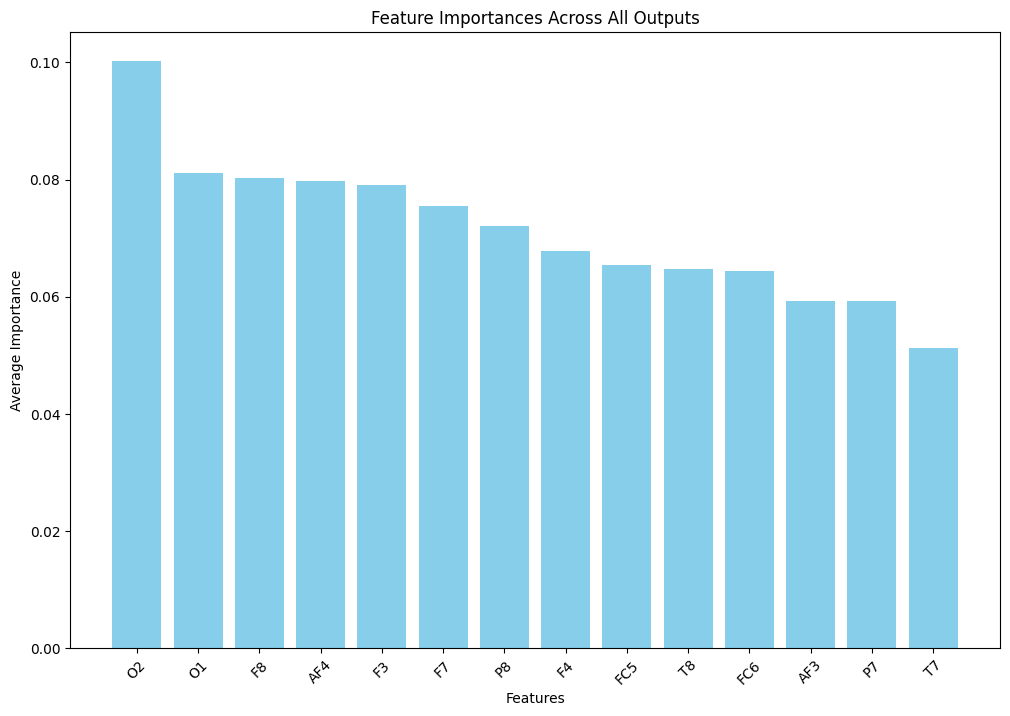

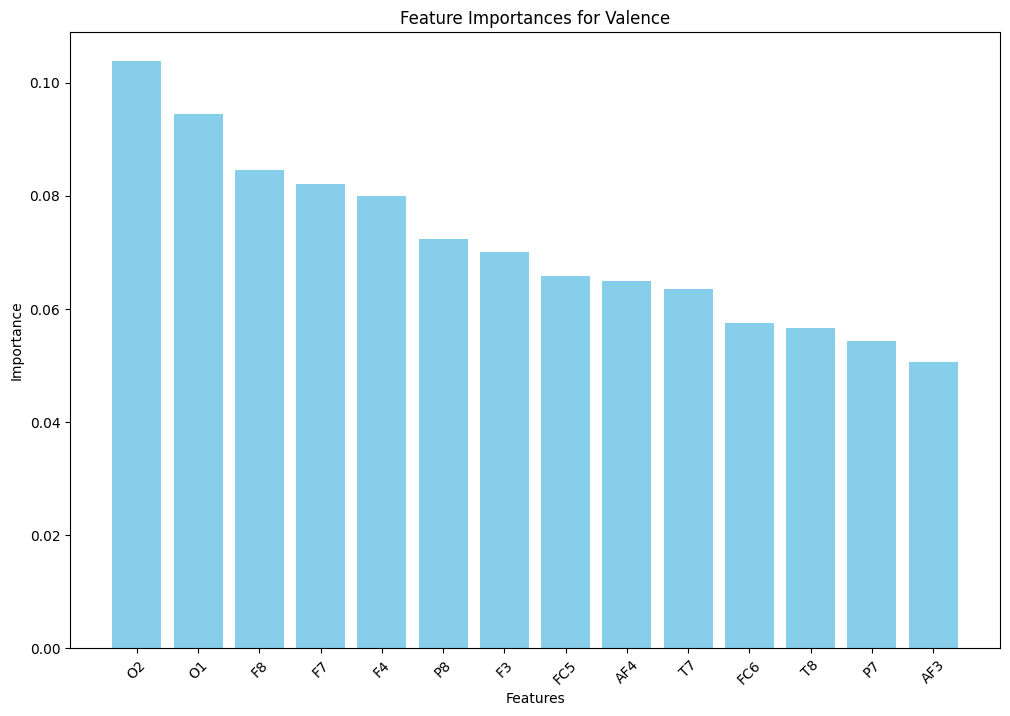

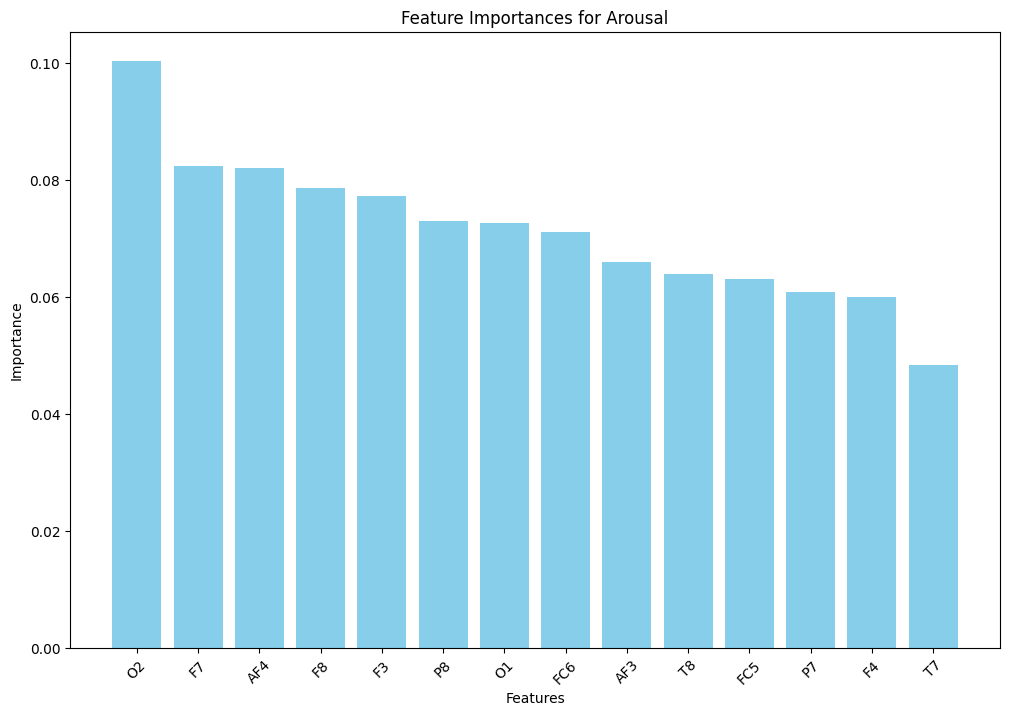

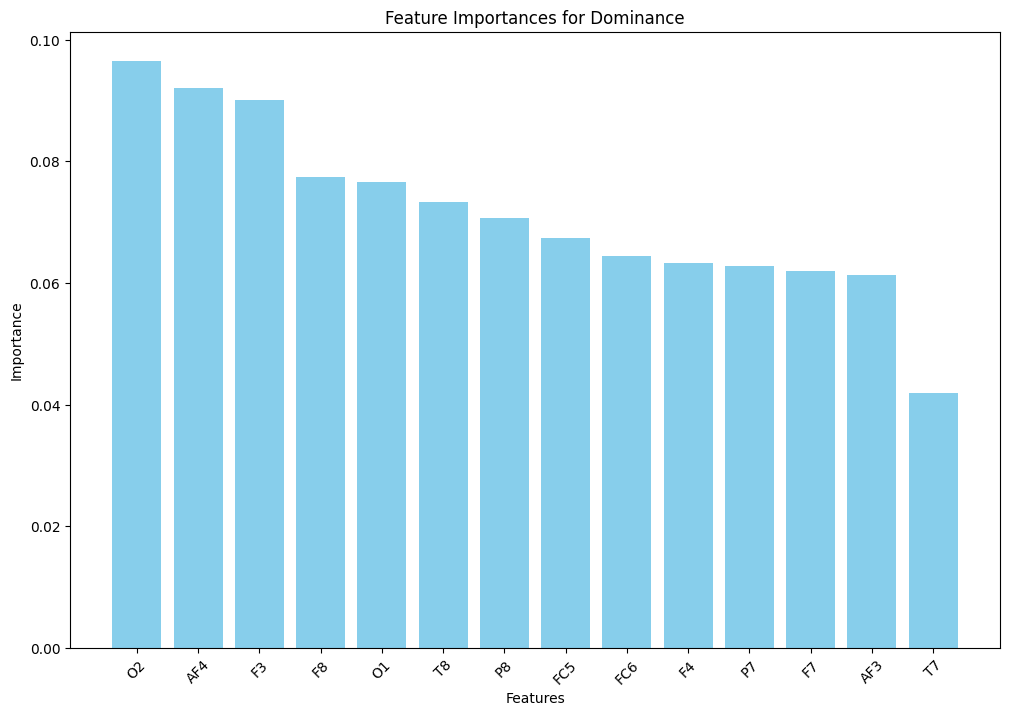

In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'multioutput_regressor' is your trained model
feature_importances = np.array([est.feature_importances_ for est in multioutput_regressor.estimators_])

# Average feature importances across all targets if you want a single representation
mean_feature_importances = np.mean(feature_importances, axis=0)

# Create a DataFrame for better visualization
features_df = pd.DataFrame({
    'Features': X.columns,
    'Importance': mean_feature_importances
})
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(12, 8))
plt.bar(features_df['Features'], features_df['Importance'], color='skyblue')
plt.title('Feature Importances Across All Outputs')
plt.xlabel('Features')
plt.ylabel('Average Importance')
plt.xticks(rotation=45)
plt.show()

# Optionally, show individual importances
for idx, target in enumerate(['Valence', 'Arousal', 'Dominance']):
    individual_df = pd.DataFrame({
        'Features': X.columns,
        'Importance': feature_importances[idx]
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    plt.bar(individual_df['Features'], individual_df['Importance'], color='skyblue')
    plt.title(f'Feature Importances for {target}')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.xticks(rotation=45)
    plt.show()


In [77]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import welch
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load the data
data = pd.read_csv('/content/drive/MyDrive/ecg emotion/grouped_df.csv')

# Drop the 'Unnamed: 0' column if it exists
data.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')

# Select the most important electrodes from the feature importance chart


In [78]:
# List of important electrodes based on your feature importance results
important_electrodes = ['O2', 'O1', 'F8', 'AF4', 'F3', 'T7', 'P8', 'F4', 'FC5', 'T8', 'FC6', 'AF3', 'P7', 'T1']  # Check if 'T1' should be included or corrected

# Filter out any electrodes not present in the DataFrame
important_electrodes = [e for e in important_electrodes if e in data.columns]

# Calculate statistical features for each existing electrode
for electrode in important_electrodes:
    data[f'{electrode}_mean'] = data[electrode].mean()
    data[f'{electrode}_std'] = data[electrode].std()



In [79]:
# Create interaction features between the most important electrodes
data['O2_F8_interaction'] = data['O2'] * data['F8']


In [80]:
data.head()

,patient_index,video_index,valence,arousal,dominance,AF3,F7,F3,FC5,T7,...,FC5_std,T8_mean,T8_std,FC6_mean,FC6_std,AF3_mean,AF3_std,P7_mean,P7_std,O2_F8_interaction
0,0,0,4.0,3.0,2.0,4380.218460,4093.074125,4158.109156,4393.518655,4295.999831,...,34.98886,4267.274204,20.20143,3935.790106,49.947786,4377.555426,33.966429,4361.127258,20.703831,1.695194e+07
1,0,1,3.0,3.0,1.0,4388.493529,4103.419670,4163.580232,4410.191818,4319.132627,...,34.98886,4267.274204,20.20143,3935.790106,49.947786,4377.555426,33.966429,4361.127258,20.703831,1.703342e+07
2,0,2,5.0,4.0,4.0,4388.187917,4108.831372,4163.864447,4410.005238,4316.097204,...,34.98886,4267.274204,20.20143,3935.790106,49.947786,4377.555426,33.966429,4361.127258,20.703831,1.704738e+07
3,0,3,4.0,3.0,2.0,4393.849871,4115.479442,4179.318814,4419.010489,4306.440208,...,34.98886,4267.274204,20.20143,3935.790106,49.947786,4377.555426,33.966429,4361.127258,20.703831,1.707054e+07
4,0,4,4.0,4.0,4.0,4388.533271,4111.512184,4240.120192,4418.574248,4300.556155,...,34.98886,4267.274204,20.20143,3935.790106,49.947786,4377.555426,33.966429,4361.127258,20.703831,1.710623e+07


In [64]:
data.head()

,patient_index,video_index,valence,arousal,dominance,AF3,F7,F3,FC5,T7,...,AF3_rolling_mean,AF3_rolling_std,AF3_rolling_max,AF3_rolling_min,AF3_rolling_var,P7_rolling_mean,P7_rolling_std,P7_rolling_max,P7_rolling_min,P7_rolling_var
0,0,0,4.0,3.0,2.0,4380.218460,4093.074125,4158.109156,4393.518655,4295.999831,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,3.0,3.0,1.0,4388.493529,4103.419670,4163.580232,4410.191818,4319.132627,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,5.0,4.0,4.0,4388.187917,4108.831372,4163.864447,4410.005238,4316.097204,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,3,4.0,3.0,2.0,4393.849871,4115.479442,4179.318814,4419.010489,4306.440208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,4,4.0,4.0,4.0,4388.533271,4111.512184,4240.120192,4418.574248,4300.556155,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
from itertools import combinations

# Generate all combinations of high-importance electrodes for cross-features
for (elec1, elec2) in combinations(important_electrodes, 2):
    data[f'cross_{elec1}_{elec2}_mult'] = data[elec1] * data[elec2]
    data[f'cross_{elec1}_{elec2}_add'] = data[elec1] + data[elec2]
    data[f'cross_{elec1}_{elec2}_ratio'] = data[elec1] / (data[elec2] + 1e-5)  # Add a small value to avoid division by zero


<ipython-input-82-863fb4a1d949>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'cross_{elec1}_{elec2}_ratio'] = data[elec1] / (data[elec2] + 1e-5)  # Add a small value to avoid division by zero
<ipython-input-82-863fb4a1d949>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'cross_{elec1}_{elec2}_mult'] = data[elec1] * data[elec2]
<ipython-input-82-863fb4a1d949>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consi

In [83]:
data.head()

,patient_index,video_index,valence,arousal,dominance,AF3,F7,F3,FC5,T7,...,cross_T8_P7_ratio,cross_FC6_AF3_mult,cross_FC6_AF3_add,cross_FC6_AF3_ratio,cross_FC6_P7_mult,cross_FC6_P7_add,cross_FC6_P7_ratio,cross_AF3_P7_mult,cross_AF3_P7_add,cross_AF3_P7_ratio
0,0,0,4.0,3.0,2.0,4380.218460,4093.074125,4158.109156,4393.518655,4295.999831,...,0.972118,1.723387e+07,8314.695332,0.898238,1.722808e+07,8313.225261,0.898539,1.917987e+07,8758.966849,1.000336
1,0,1,3.0,3.0,1.0,4388.493529,4103.419670,4163.580232,4410.191818,4319.132627,...,0.981698,1.728681e+07,8327.616125,0.897602,1.715251e+07,8293.522063,0.904631,1.910925e+07,8742.892995,1.007830
2,0,2,5.0,4.0,4.0,4388.187917,4108.831372,4163.864447,4410.005238,4316.097204,...,0.981000,1.727861e+07,8325.715110,0.897301,1.715803e+07,8295.092999,0.903607,1.912182e+07,8745.753723,1.007027
3,0,3,4.0,3.0,2.0,4393.849871,4115.479442,4179.318814,4419.010489,4306.440208,...,0.980023,1.733324e+07,8338.736991,0.897820,1.717148e+07,8297.732806,0.906278,1.912575e+07,8746.695556,1.009420
4,0,4,4.0,4.0,4.0,4388.533271,4111.512184,4240.120192,4418.574248,4300.556155,...,0.981643,1.735507e+07,8343.173018,0.901130,1.716885e+07,8296.085354,0.910904,1.905258e+07,8729.978878,1.010846


In [84]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Define features and target
X = data.drop(['valence','dominance','arousal'], axis=1)  # Use all other features to predict valence
y = data[['valence','dominance','arousal']]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


RMSE Valence: 1.250507477075461
RMSE Arousal: 1.0544028053595342
RMSE Dominance: 1.1532292884848163


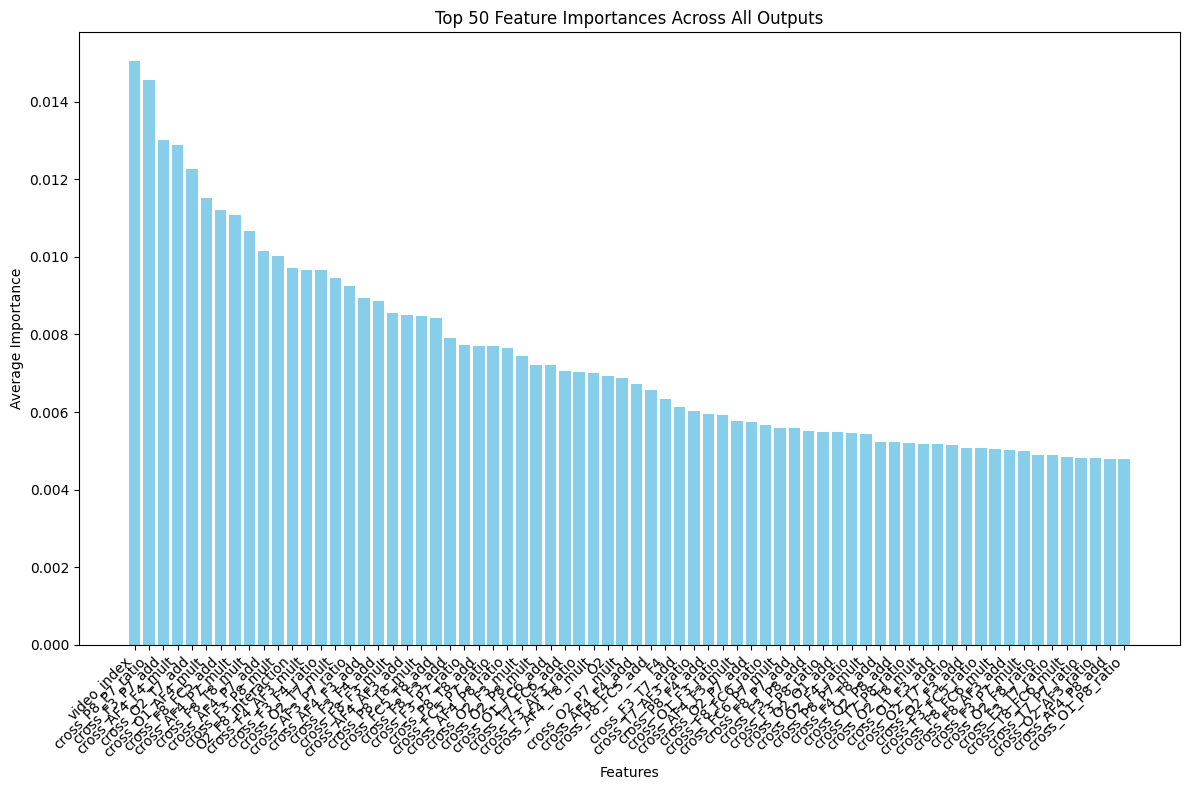

In [95]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Initialize XGBoost regressor
from sklearn.multioutput import MultiOutputRegressor

xgb_regressor = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                                  max_depth=5, alpha=10, n_estimators=100)

# Wrap XGBoost with MultiOutputRegressor
multioutput_regressor = MultiOutputRegressor(xgb_regressor)

# Train the model
multioutput_regressor.fit(X_train, y_train)

# Predictions on the test set
y_pred = multioutput_regressor.predict(X_test)

# Evaluate the model
from sklearn.metrics import mean_squared_error

rmse_valence = mean_squared_error(y_test['valence'], y_pred[:, 0], squared=False)
rmse_arousal = mean_squared_error(y_test['arousal'], y_pred[:, 1], squared=False)
rmse_dominance = mean_squared_error(y_test['dominance'], y_pred[:, 2], squared=False)

print("RMSE Valence:", rmse_valence)
print("RMSE Arousal:", rmse_arousal)
print("RMSE Dominance:", rmse_dominance)

# Extract feature importances from each estimator within the MultiOutputRegressor
feature_importances = np.array([est.feature_importances_ for est in multioutput_regressor.estimators_])

# Compute the mean feature importances across all targets
mean_feature_importances = np.mean(feature_importances, axis=0)

# Create a DataFrame to hold feature names and their average importance
features_df = pd.DataFrame({
    'Features': X_train.columns,
    'Importance': mean_feature_importances
})
features_df.sort_values(by='Importance', ascending=False, inplace=True)

# Select the top 50 features
top_features_df = features_df.head(70)

# Plotting
plt.figure(figsize=(12, 8))
plt.bar(top_features_df['Features'], top_features_df['Importance'], color='skyblue')
plt.title('Top 50 Feature Importances Across All Outputs')
plt.xlabel('Features')
plt.ylabel('Average Importance')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()

In [87]:
import pandas as pd
from scipy.stats import f_oneway


In [88]:
# Grouping data by 'video_index' and collecting emotional response measurements
grouped_data = data.groupby('video_index')


In [89]:
# Prepare lists to hold the emotional responses per video
valence_lists = [group['valence'].values for name, group in grouped_data]
arousal_lists = [group['arousal'].values for name, group in grouped_data]
dominance_lists = [group['dominance'].values for name, group in grouped_data]


In [90]:
# Perform ANOVA for each emotional response
valence_f, valence_p = f_oneway(*valence_lists)
arousal_f, arousal_p = f_oneway(*arousal_lists)
dominance_f, dominance_p = f_oneway(*dominance_lists)

print("ANOVA results for Valence:", "F =", valence_f, "P-value =", valence_p)
print("ANOVA results for Arousal:", "F =", arousal_f, "P-value =", arousal_p)
print("ANOVA results for Dominance:", "F =", dominance_f, "P-value =", dominance_p)


ANOVA results for Valence: F = 36.11873571143447 P-value = 1.0538199769047305e-69
ANOVA results for Arousal: F = 12.601856383152258 P-value = 3.836534710136601e-28
ANOVA results for Dominance: F = 11.949259592571387 P-value = 1.1218844764304803e-26


In [92]:
data.head()

,patient_index,video_index,valence,arousal,dominance,AF3,F7,F3,FC5,T7,...,cross_T8_P7_ratio,cross_FC6_AF3_mult,cross_FC6_AF3_add,cross_FC6_AF3_ratio,cross_FC6_P7_mult,cross_FC6_P7_add,cross_FC6_P7_ratio,cross_AF3_P7_mult,cross_AF3_P7_add,cross_AF3_P7_ratio
0,0,0,4.0,3.0,2.0,4380.218460,4093.074125,4158.109156,4393.518655,4295.999831,...,0.972118,1.723387e+07,8314.695332,0.898238,1.722808e+07,8313.225261,0.898539,1.917987e+07,8758.966849,1.000336
1,0,1,3.0,3.0,1.0,4388.493529,4103.419670,4163.580232,4410.191818,4319.132627,...,0.981698,1.728681e+07,8327.616125,0.897602,1.715251e+07,8293.522063,0.904631,1.910925e+07,8742.892995,1.007830
2,0,2,5.0,4.0,4.0,4388.187917,4108.831372,4163.864447,4410.005238,4316.097204,...,0.981000,1.727861e+07,8325.715110,0.897301,1.715803e+07,8295.092999,0.903607,1.912182e+07,8745.753723,1.007027
3,0,3,4.0,3.0,2.0,4393.849871,4115.479442,4179.318814,4419.010489,4306.440208,...,0.980023,1.733324e+07,8338.736991,0.897820,1.717148e+07,8297.732806,0.906278,1.912575e+07,8746.695556,1.009420
4,0,4,4.0,4.0,4.0,4388.533271,4111.512184,4240.120192,4418.574248,4300.556155,...,0.981643,1.735507e+07,8343.173018,0.901130,1.716885e+07,8296.085354,0.910904,1.905258e+07,8729.978878,1.010846


In [94]:
data.to_csv('data.csv',sep=',')

In [96]:
top_features_df

,Features,Importance
1,video_index,0.015040
231,cross_P8_P7_ratio,0.014551
191,cross_F3_P7_add,0.013026
151,cross_AF4_F4_mult,0.012880
56,cross_O2_T7_add,0.012277
...,...,...
259,cross_T8_FC6_mult,0.004839
213,cross_T7_P7_ratio,0.004816
75,cross_O2_AF3_ratio,0.004808
149,cross_AF4_P8_add,0.004794


In [102]:
# Assuming top_features_df['Features'] contains the top 70 feature names
top_features = top_features_df['Features'].tolist()

# Subset the dataset to include only the top 70 features
X_top_features = data[top_features]

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_top_features)

# Convert the normalized data back to a DataFrame for further use
X_normalized_df = pd.DataFrame(X_normalized, columns=top_features)

X_normalized_df.head()


,video_index,cross_P8_P7_ratio,cross_F3_P7_add,cross_AF4_F4_mult,cross_O2_T7_add,cross_O1_AF4_mult,cross_F8_FC5_add,cross_AF4_P7_mult,cross_F8_T8_mult,cross_AF4_P7_add,...,cross_F8_FC6_mult,cross_F8_AF3_add,cross_F3_P7_mult,cross_O2_F8_ratio,cross_F3_T7_ratio,cross_T8_FC6_mult,cross_T7_P7_ratio,cross_O2_AF3_ratio,cross_AF4_P8_add,cross_O1_P8_ratio
0,-1.638356,-1.037597,0.319147,-1.071700,-0.011472,-0.516533,-0.484531,0.072844,-0.505947,0.092326,...,-0.283347,-0.155534,0.300728,0.471517,0.159965,-0.245365,-1.158187,0.173513,-0.357840,-0.311550
1,-1.445608,0.895536,-0.258927,0.520651,0.706879,0.844447,0.133602,0.578857,0.324491,0.564016,...,0.238751,0.316907,-0.257329,0.163698,-0.422782,0.229612,0.678360,0.075126,0.972329,-0.051784
2,-1.252861,0.448018,-0.153265,0.806225,0.529122,0.809722,0.255409,0.630961,0.487573,0.617953,...,0.358051,0.437436,-0.153377,-0.041685,-0.312131,0.195335,0.437312,0.019566,0.834712,0.088392
3,-1.060113,0.830773,0.175437,0.692352,0.637256,0.713822,0.259078,0.295255,0.081403,0.283547,...,0.341022,0.381418,0.189841,0.414174,0.543560,0.176628,0.242666,0.176292,0.654608,0.198859
4,-0.867365,1.157278,1.688195,0.748080,0.935314,0.677151,0.096077,0.171725,-0.213784,0.152237,...,0.382866,0.130116,1.749077,0.933166,2.844311,0.308601,0.453990,0.573821,0.661513,0.124657


In [103]:
X_normalized_df=X_normalized_df.drop(columns=['video_index'])

In [110]:
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensionality
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X_normalized_df)

# Convert PCA results back to a DataFrame
X_pca_df = pd.DataFrame(X_pca)

# Display the shape of the original normalized data and the PCA-transformed data
X_normalized_df.shape, X_pca_df.shape


((414, 69), (414, 8))

In [111]:
y = data_cleaned[['valence','dominance','arousal']]


In [118]:
from sklearn.metrics import r2_score, mean_absolute_error, explained_variance_score

# Assuming the predictions are stored and the models have been trained and evaluated
# Calculate additional metrics for the reported RMSE values
evaluation_metrics = {}

for target in targets:
    # Fetching the last test set and predictions made for each target (assuming from previous context)
    y_target_test = data_cleaned[target].iloc[y_test.index]  # Update index slicing based on actual data handling
    y_pred = svr_model.predict(X_test_pca)  # This assumes predictions are made and model is trained

    # Compute additional metrics
    r2 = r2_score(y_target_test, y_pred)
    mae = mean_absolute_error(y_target_test, y_pred)
    exp_var = explained_variance_score(y_target_test, y_pred)

    # Store all metrics including previously computed RMSE
    evaluation_metrics[target] = {
        'RMSE': svr_reports[target],
        'R2 Score': r2,
        'MAE': mae,
        'Explained Variance': exp_var
    }

evaluation_metrics


{'valence': {'RMSE': 1.0670459510474202,
  'R2 Score': -0.16987439658529113,
  'MAE': 0.9066322572100203,
  'Explained Variance': -0.1619904644144341},
 'arousal': {'RMSE': 1.1074310922677646,
  'R2 Score': -0.0805490928711039,
  'MAE': 0.877393029212126,
  'Explained Variance': -0.08054819147837633},
 'dominance': {'RMSE': 1.0974262518956162,
  'R2 Score': -0.05857528887060037,
  'MAE': 0.9112083978596285,
  'Explained Variance': -0.0581716696844683}}

In [119]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, explained_variance_score

# Assuming X_normalized_df is prepared and y contains the continuous targets 'valence', 'arousal', 'dominance'
svr_reports_all_features = {}
targets = ['valence', 'arousal', 'dominance']  # Define the targets if not already defined

for target in targets:
    # Splitting the normalized data into train and test sets for each target
    y_target = data_cleaned[target]
    X_train_norm, X_test_norm, y_train, y_test = train_test_split(X_normalized_df, y_target, test_size=0.2, random_state=42)

    # Train SVR model using RBF kernel for each target
    svr_model = SVR()
    svr_model.fit(X_train_norm, y_train)

    # Predict on the test set for each target
    y_pred = svr_model.predict(X_test_norm)

    # Evaluate the model using RMSE, R2, MAE, and explained variance for each target
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    exp_var = explained_variance_score(y_test, y_pred)

    # Store all metrics
    svr_reports_all_features[target] = {
        'RMSE': rmse,
        'R2 Score': r2,
        'MAE': mae,
        'Explained Variance': exp_var
    }

svr_reports_all_features


{'valence': {'RMSE': 1.0751066875898307,
  'R2 Score': -0.15689790529083414,
  'MAE': 0.9344109883226915,
  'Explained Variance': -0.15676396642644197},
 'arousal': {'RMSE': 1.1075943840108435,
  'R2 Score': -0.1810117210161153,
  'MAE': 0.8982672040841139,
  'Explained Variance': -0.18076613693272603},
 'dominance': {'RMSE': 1.074247557021375,
  'R2 Score': -0.014331263363955626,
  'MAE': 0.8898361177558008,
  'Explained Variance': -0.014209246369917938}}



| **Target Variable** | **Metric**          | **SVM Only** | **PCA with SVM** | **Observation**                                         |
|---------------------|---------------------|--------------|------------------|---------------------------------------------------------|
| **Valence**         | RMSE                | 1.075        | 1.067            | PCA slightly better in RMSE.                            |
|                     | R² Score            | -0.157       | -0.170           | PCA worse in R².                                        |
|                     | MAE                 | 0.934        | 0.907            | PCA slightly better in MAE.                             |
|                     | Explained Variance  | -0.157       | -0.162           | PCA worse in explained variance.                        |
| **Arousal**         | RMSE                | 1.108        | 1.107            | Similar RMSE.                                           |
|                     | R² Score            | -0.181       | -0.081           | PCA significantly better in R².                         |
|                     | MAE                 | 0.898        | 0.877            | PCA slightly better in MAE.                             |
|                     | Explained Variance  | -0.181       | -0.081           | PCA significantly better in explained variance.         |
| **Dominance**       | RMSE                | 1.074        | 1.097            | SVM better in RMSE.                                     |
|                     | R² Score            | -0.014       | -0.059           | SVM better in R².                                       |
|                     | MAE                 | 0.890        | 0.911            | SVM better in MAE.                                      |
|                     | Explained Variance  | -0.014       | -0.058           | SVM better in explained variance.                       |



In [126]:
# Assuming X_normalized_df is already defined and data_cleaned contains the targets
# Define features and target for X_normalized_df
X = X_normalized_df  # Use normalized features
y = data_cleaned[['valence', 'dominance', 'arousal']]  # Targets

# Split data into training and testing sets for normalized data
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost regressor
xgb_regressor_norm = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                                      max_depth=5, alpha=10, n_estimators=100)

# Wrap XGBoost with MultiOutputRegressor for normalized data
multioutput_regressor_norm = MultiOutputRegressor(xgb_regressor_norm)

# Train the model on normalized data
multioutput_regressor_norm.fit(X_train_norm, y_train_norm)

# Predictions on the test set for normalized data
y_pred_norm = multioutput_regressor_norm.predict(X_test_norm)

# Evaluate the model on normalized data
rmse_valence_norm = mean_squared_error(y_test_norm['valence'], y_pred_norm[:, 0], squared=False)
rmse_arousal_norm = mean_squared_error(y_test_norm['arousal'], y_pred_norm[:, 1], squared=False)
rmse_dominance_norm = mean_squared_error(y_test_norm['dominance'], y_pred_norm[:, 2], squared=False)

rmse_valence_norm, rmse_arousal_norm, rmse_dominance_norm


(1.0936020820406993, 1.0033298901184469, 1.0644281312785115)

In [127]:
metrics_norm = {
    'R2 Score': r2_score(y_test_norm, y_pred_norm),
    'MAE': mean_absolute_error(y_test_norm, y_pred_norm),
    'Explained Variance': explained_variance_score(y_test_norm, y_pred_norm),
    'MSE': mean_squared_error(y_test_norm, y_pred_norm)
}

In [128]:
print(metrics_norm)

{'R2 Score': -0.06991802965484047, 'MAE': 0.8833512887928562, 'Explained Variance': -0.06837752143162894, 'MSE': 1.1283974472876726}


In [129]:
# Assuming X_normalized_df is already defined and data_cleaned contains the targets
# Define features and target for X_normalized_df
X = X_pca_df  # Use normalized features
y = data_cleaned[['valence', 'dominance', 'arousal']]  # Targets

# Split data into training and testing sets for normalized data
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost regressor
xgb_regressor_norm = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                                      max_depth=5, alpha=10, n_estimators=100)

# Wrap XGBoost with MultiOutputRegressor for normalized data
multioutput_regressor_norm = MultiOutputRegressor(xgb_regressor_norm)

# Train the model on normalized data
multioutput_regressor_norm.fit(X_train_norm, y_train_norm)

# Predictions on the test set for normalized data
y_pred_norm = multioutput_regressor_norm.predict(X_test_norm)

# Evaluate the model on normalized data
rmse_valence_norm = mean_squared_error(y_test_norm['valence'], y_pred_norm[:, 0], squared=False)
rmse_arousal_norm = mean_squared_error(y_test_norm['arousal'], y_pred_norm[:, 1], squared=False)
rmse_dominance_norm = mean_squared_error(y_test_norm['dominance'], y_pred_norm[:, 2], squared=False)

rmse_valence_norm, rmse_arousal_norm, rmse_dominance_norm


(1.0281472053339835, 1.0125458927927116, 1.0764967425099083)

In [130]:
metrics_norm = {
    'R2 Score': r2_score(y_test_norm, y_pred_norm),
    'MAE': mean_absolute_error(y_test_norm, y_pred_norm),
    'Explained Variance': explained_variance_score(y_test_norm, y_pred_norm),
    'MSE': mean_squared_error(y_test_norm, y_pred_norm)
}

In [131]:
print(metrics_norm)

{'R2 Score': -0.03982490962858246, 'MAE': 0.8845459512706478, 'Explained Variance': -0.038268441579373404, 'MSE': 1.1007243911358218}



| **Metric**          | **Normalized Data** | **PCA Data** | **Interpretation**                                           |
|---------------------|---------------------|--------------|--------------------------------------------------------------|
| **R² Score**        | -0.0699             | -0.0398      | Higher (or less negative) is better; PCA shows a better score. |
| **Mean Absolute Error (MAE)** | 0.8834             | 0.8845      | Lower is better; normalized data shows marginally better MAE.  |
| **Explained Variance**  | -0.0684             | -0.0383      | Higher (or less negative) is better; PCA shows a better score. |
| **Mean Squared Error (MSE)** | 1.1284             | 1.1007      | Lower is better; PCA model has a better MSE.                    |





| **Model**      | **Metric**          | **Valence**         | **Arousal**         | **Dominance**       | **Overall (XGBoost)** |
|----------------|---------------------|---------------------|---------------------|---------------------|-----------------------|
| **XGBoost**    | R² Score            | -                   | -                   | -                   | -0.0398               |
|                | MAE                 | -                   | -                   | -                   | 0.885                 |
|                | Explained Variance  | -                   | -                   | -                   | -0.0383               |
|                | MSE                 | -                   | -                   | -                   | 1.101                 |
| **SVM**        | RMSE                | 1.075               | 1.108               | 1.074               | -                     |
|                | R² Score            | -0.157              | -0.181              | -0.014              | -                     |
|                | MAE                 | 0.934               | 0.898               | 0.890               | -                     |
|                | Explained Variance  | -0.157              | -0.181              | -0.014              | -                     |



In [132]:
X = X_pca_df
y = data_cleaned[['valence', 'dominance', 'arousal']]  # Targets

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [141]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam



In [137]:
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='sigmoid')  # Use 'sigmoid' or 'softmax', depending on the nature of the target
])

In [138]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Train the model
model.fit(X_train_pca, y_train, epochs=50, batch_size=32, validation_data=(X_test_pca, y_test))


Epoch 1/50
11/11 [==============================] - 6s 132ms/step - loss: 1.1977 - mae: 0.8949 - val_loss: 1.1621 - val_mae: 0.9131
Epoch 2/50
11/11 [==============================] - 0s 18ms/step - loss: 1.0861 - mae: 0.8627 - val_loss: 1.1163 - val_mae: 0.8988
Epoch 3/50
11/11 [==============================] - 0s 25ms/step - loss: 1.0226 - mae: 0.8477 - val_loss: 1.0954 - val_mae: 0.8920
Epoch 4/50
11/11 [==============================] - 0s 20ms/step - loss: 1.0145 - mae: 0.8500 - val_loss: 1.0843 - val_mae: 0.8874
Epoch 5/50
11/11 [==============================] - 0s 17ms/step - loss: 0.9979 - mae: 0.8454 - val_loss: 1.0780 - val_mae: 0.8843
Epoch 6/50
11/11 [==============================] - 0s 14ms/step - loss: 0.9756 - mae: 0.8355 - val_loss: 1.0743 - val_mae: 0.8824
Epoch 7/50
11/11 [==============================] - 0s 15ms/step - loss: 0.9884 - mae: 0.8405 - val_loss: 1.0718 - val_mae: 0.8810
Epoch 8/50
11/11 [==============================] - 0s 27ms/step - loss: 0.9832 - 

In [139]:
loss, mae = model.evaluate(X_test_pca, y_test)
print(f"Loss: {loss}, Mean Absolute Error: {mae}")

3/3 [==============================] - 0s 7ms/step - loss: 1.0856 - mae: 0.8881
Loss: 1.0856493711471558, Mean Absolute Error: 0.8881276845932007


In [140]:
y_pred = model.predict(X_test_pca)

# Evaluate predictions
from sklearn.metrics import mean_squared_error
rmse_valence = mean_squared_error(y_test['valence'], y_pred[:, 0], squared=False)
rmse_arousal = mean_squared_error(y_test['arousal'], y_pred[:, 1], squared=False)
rmse_dominance = mean_squared_error(y_test['dominance'], y_pred[:, 2], squared=False)

print("RMSE Valence:", rmse_valence)
print("RMSE Arousal:", rmse_arousal)
print("RMSE Dominance:", rmse_dominance)

3/3 [==============================] - 0s 8ms/step
RMSE Valence: 1.0095855251653338
RMSE Arousal: 1.0163483835569944
RMSE Dominance: 1.0800281620079961


In [164]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Reshape the data for CNN
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the CNN model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=1))
model.add(Dropout(0.25))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=1))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3))  # 3 outputs for valence, arousal, and dominance

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Train the model with early stopping
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train_reshaped, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping])

# Evaluate the model
y_pred = model.predict(X_test_reshaped)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred, squared=False)

print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", mse)

Epoch 1/100
9/9 [==============================] - 7s 125ms/step - loss: 4.4569 - mean_absolute_error: 1.5501 - val_loss: 1.0721 - val_mean_absolute_error: 0.8885
Epoch 2/100
9/9 [==============================] - 0s 28ms/step - loss: 4.2502 - mean_absolute_error: 1.5443 - val_loss: 1.0656 - val_mean_absolute_error: 0.8885
Epoch 3/100
9/9 [==============================] - 0s 31ms/step - loss: 3.7327 - mean_absolute_error: 1.4595 - val_loss: 1.0647 - val_mean_absolute_error: 0.8890
Epoch 4/100
9/9 [==============================] - 0s 30ms/step - loss: 2.9431 - mean_absolute_error: 1.3373 - val_loss: 1.0596 - val_mean_absolute_error: 0.8854
Epoch 5/100
9/9 [==============================] - 0s 45ms/step - loss: 3.3477 - mean_absolute_error: 1.4034 - val_loss: 1.0529 - val_mean_absolute_error: 0.8858
Epoch 6/100
9/9 [==============================] - 0s 32ms/step - loss: 3.3487 - mean_absolute_error: 1.3531 - val_loss: 1.0467 - val_mean_absolute_error: 0.8828
Epoch 7/100
9/9 [==========

In [165]:
from sklearn.metrics import mean_squared_error

# Predict using the CNN model
y_pred = model.predict(X_test_reshaped)

# Calculate RMSE for each target variable separately
rmse_valence = mean_squared_error(y_test['valence'], y_pred[:, 0], squared=False)
rmse_arousal = mean_squared_error(y_test['arousal'], y_pred[:, 1], squared=False)
rmse_dominance = mean_squared_error(y_test['dominance'], y_pred[:, 2], squared=False)

print("RMSE Valence:", rmse_valence)
print("RMSE Arousal:", rmse_arousal)
print("RMSE Dominance:", rmse_dominance)


3/3 [==============================] - 0s 13ms/step
RMSE Valence: 1.0160735003275578
RMSE Arousal: 1.0062781745206995
RMSE Dominance: 1.1642712079804443


In [166]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

# Predict using the CNN model
y_pred = model.predict(X_test_reshaped)

# Calculate RMSE for each target variable separately
rmse_valence = mean_squared_error(y_test['valence'], y_pred[:, 0], squared=False)
rmse_arousal = mean_squared_error(y_test['arousal'], y_pred[:, 1], squared=False)
rmse_dominance = mean_squared_error(y_test['dominance'], y_pred[:, 2], squared=False)

# Calculate MAE for each target variable separately
mae_valence = mean_absolute_error(y_test['valence'], y_pred[:, 0])
mae_arousal = mean_absolute_error(y_test['arousal'], y_pred[:, 1])
mae_dominance = mean_absolute_error(y_test['dominance'], y_pred[:, 2])

# Calculate R² score for each target variable separately
r2_valence = r2_score(y_test['valence'], y_pred[:, 0])
r2_arousal = r2_score(y_test['arousal'], y_pred[:, 1])
r2_dominance = r2_score(y_test['dominance'], y_pred[:, 2])

# Calculate Explained Variance for each target variable separately
ev_valence = explained_variance_score(y_test['valence'], y_pred[:, 0])
ev_arousal = explained_variance_score(y_test['arousal'], y_pred[:, 1])
ev_dominance = explained_variance_score(y_test['dominance'], y_pred[:, 2])

print("RMSE Valence:", rmse_valence)
print("RMSE Arousal:", rmse_arousal)
print("RMSE Dominance:", rmse_dominance)

print("MAE Valence:", mae_valence)
print("MAE Arousal:", mae_arousal)
print("MAE Dominance:", mae_dominance)

print("R² Score Valence:", r2_valence)
print("R² Score Arousal:", r2_arousal)
print("R² Score Dominance:", r2_dominance)

print("Explained Variance Valence:", ev_valence)
print("Explained Variance Arousal:", ev_arousal)
print("Explained Variance Dominance:", ev_dominance)


3/3 [==============================] - 0s 11ms/step
RMSE Valence: 1.0160735003275578
RMSE Arousal: 1.0062781745206995
RMSE Dominance: 1.1642712079804443
MAE Valence: 0.8716518243423091
MAE Arousal: 0.8669298775575948
MAE Dominance: 0.977008116023524
R² Score Valence: -0.03333742277813423
R² Score Arousal: 0.025170138457799807
R² Score Dominance: -0.19145975456318354
Explained Variance Valence: -0.012473419476748848
Explained Variance Arousal: 0.02634829038652764
Explained Variance Dominance: -0.1787841328981823



| **Metric**          | **Valence**         | **Arousal**         | **Dominance**       |
|---------------------|---------------------|---------------------|---------------------|
| **RMSE**            | 1.0161              | 1.0063              | 1.1643              |
| **MAE**             | 0.8717              | 0.8669              | 0.9770              |
| **R² Score**        | -0.0333             | 0.0252              | -0.1915             |
| **Explained Variance** | -0.0125             | 0.0263              | -0.1788             |
